In [1]:
import sys
import os
from copy import deepcopy
# direc = os.path.dirname(__file__)
# pri&
# caution: path[0] is reserved for script path (or '' in REPL)
# print(str(path)+'/ppo')
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

from sb3_contrib.ppo_mask import MaskablePPO
# from stable_baselines3 import PPO
from assignment import NormalizedEnv, RemoveActionEnv, AssignmentGame
from a_star import A_Star
from SA_baseline import recuit
from greedy_baseline import baseline
from sb3_contrib.common.maskable.utils import get_action_masks

import pickle
from itertools import permutations
import networkx as nx

import torch

from torch_geometric.data import Batch
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import WLConv
from torch_geometric.utils.convert import from_networkx

i_id = 0
K = 100
with open(f'game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}.npy')
dests = np.load(f'destinations_K{K}.npy')
env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
                    #   obs_mode='action', 
                    action_mode = 'all_nodes',
                      change_instance = False, rewards_mode='normalized_terminal', instance_id = i_id)

In [124]:
routes = np.load('routes_K100.npy')
dests = np.array(np.load('destinations_K100.npy'), dtype=int)
route = routes[0]
dest = [g.hub] + list(dests[0])
def get_graph_data(costs_mat, route, dest):

    G = nx.DiGraph()
    G.add_nodes_from(list(range(len(dest))))
    node_attrs = dict()
    edges = []
    # vehicle_edges = []
    for m in range(len(route)):
        j = 0
        # vehicle_edges.append([])
        while not (j > 0 and route[m, j] == 0):
            if route[m, j] == 0:
                gained_on_substitution = 0.
            else:
                gained_on_substitution = route[m, j-1] + route[m, j+1] -(
                        costs_mat[m, dest[int(route[m, j-2])], dest[int(route[m, j+2])]]
                    )
            node_attrs[int(route[m, j])] = {
                     'vehicle' : m, 
                     'x' : [dest[int(route[m, j])], m, gained_on_substitution], 
                     'pos' : (dest[int(route[m, j])]//15, dest[int(route[m, j])]%15)
            }
            # G_ncolors[int(route[m, j])] = colors[m]
            # if int(route[m, j]):
            #     G_ncolors.append(colors[m])
            # G_pos[int(route[m, j])] = (dest[int(route[m, j])]//15, dest[int(route[m, j])]%15)
            # print(int(route[m, j]), int(route[m, j+2]))
            edges.append(
                (
                    int(route[m, j]), int(route[m, j+2]), route[m, j+1]
                )
            )
            # vehicle_edges[m].append((int(route[m, j]), int(route[m, j+2])))
            j+=2

    G.add_weighted_edges_from(edges)
    nx.set_node_attributes(G, node_attrs)
    return G
def render_graph(G):
    colors = []#'#1f78b4' for _ in range(len(G.nodes))]
    colors.append('lightcoral')#'red')
    colors.append('lightgreen')
    colors.append('lightyellow')
    colors.append('lightblue')
    G_ncolors = [colors[m] for m in nx.get_node_attributes(G,'vehicle').values()]
    G_ncolors[0] = 'gray'
    
    _, ax = plt.subplots(figsize=(10, 7))
    weights = list(nx.get_edge_attributes(G,'weight').values())
    nx.draw_networkx(G, 
                     pos = nx.get_node_attributes(G,'pos'),  
                     ax=ax, 
                     font_size=8, 
                     with_labels=True,
                     node_size=150, 
                     node_color=G_ncolors,
                     edge_color = weights,
                     edge_cmap=plt.cm.jet,
                     node_shape='s',
                     arrows=True
    )
    
    # handles, labels = ax.get_legend_handles_labels()
    # labels = list(range(len(colors)))
    for i in range(len(colors)):
        ax.scatter([0],[0],color=colors[i],label=f'Vehicle {i}')
    ax.scatter([0],[0],color='white')
    
    # reverse the order
    plt.draw()
    plt.legend(bbox_to_anchor=(1.4, 1.0), loc='upper right')
    mesh = ax.pcolormesh(([], []), cmap = plt.cm.jet)
    mesh.set_clim(np.min(weights),np.max(weights))
    # Visualizing colorbar part -start
    plt.colorbar(mesh,ax=ax)
    # plt.colorbar()
    # plt.style.use("dark_background")
    # plt.legend()
    plt.show()
    
    return nx.to_latex(G, nx.get_node_attributes(G,'pos'), node_options=dict(zip(range(len(G_ncolors)), G_ncolors)))
    

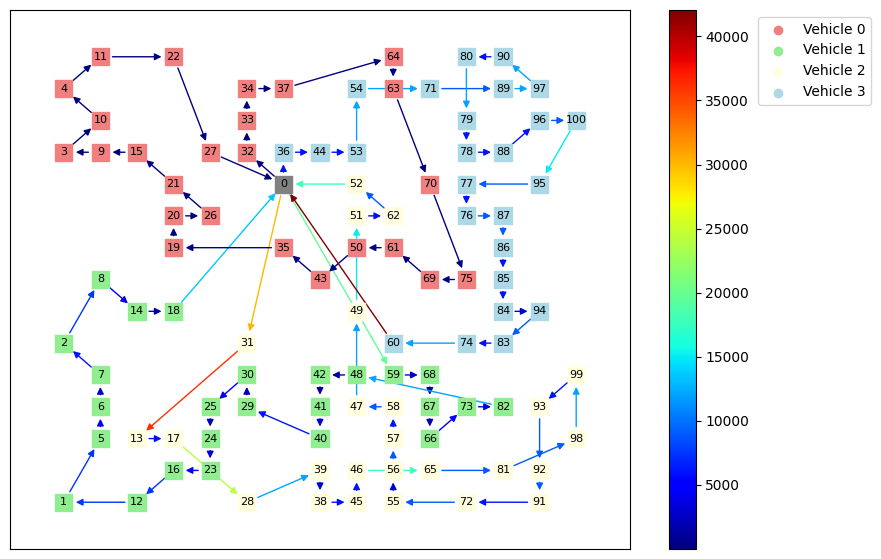

In [116]:
G0 = get_graph_data(g.cost_matrix, route, dest)
latex = render_graph(G0)

In [117]:
print(latex)

\documentclass{report}
\usepackage{tikz}
\usepackage{subcaption}

\begin{document}
\begin{figure}
  \begin{tikzpicture}
      \draw
        (6, 10) node[gray] (0){0}
        (0, 0) node[lightgreen] (1){1}
        (0, 5) node[lightgreen] (2){2}
        (0, 11) node[lightcoral] (3){3}
        (0, 13) node[lightcoral] (4){4}
        (1, 2) node[lightgreen] (5){5}
        (1, 3) node[lightgreen] (6){6}
        (1, 4) node[lightgreen] (7){7}
        (1, 7) node[lightgreen] (8){8}
        (1, 11) node[lightcoral] (9){9}
        (1, 12) node[lightcoral] (10){10}
        (1, 14) node[lightcoral] (11){11}
        (2, 0) node[lightgreen] (12){12}
        (2, 2) node[lightyellow] (13){13}
        (2, 6) node[lightgreen] (14){14}
        (2, 11) node[lightcoral] (15){15}
        (3, 1) node[lightgreen] (16){16}
        (3, 2) node[lightyellow] (17){17}
        (3, 6) node[lightgreen] (18){18}
        (3, 8) node[lightcoral] (19){19}
        (3, 9) node[lightcoral] (20){20}
        (3, 10) node[lig

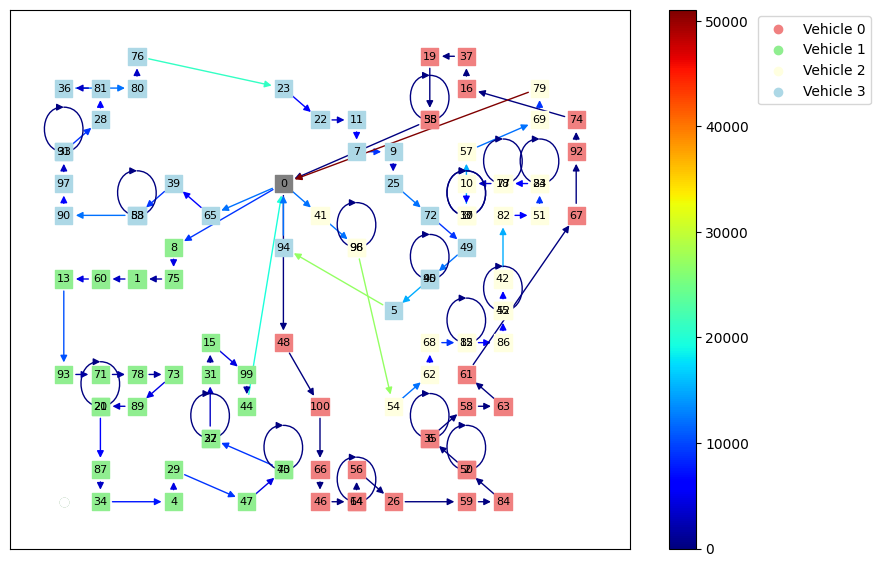

'\\documentclass{report}\n\\usepackage{tikz}\n\\usepackage{subcaption}\n\n\\begin{document}\n\\begin{figure}\n  \\begin{tikzpicture}\n      \\draw\n        (6, 10) node[gray] (0){0}\n        (2, 7) node[lightgreen] (1){1}\n        (11, 1) node[lightcoral] (2){2}\n        (11, 9) node[lightyellow] (3){3}\n        (3, 0) node[lightgreen] (4){4}\n        (9, 6) node[lightblue] (5){5}\n        (10, 2) node[lightcoral] (6){6}\n        (8, 11) node[lightblue] (7){7}\n        (3, 8) node[lightgreen] (8){8}\n        (9, 11) node[lightblue] (9){9}\n        (11, 10) node[lightyellow] (10){10}\n        (8, 12) node[lightblue] (11){11}\n        (11, 5) node[lightyellow] (12){12}\n        (0, 7) node[lightgreen] (13){13}\n        (8, 0) node[lightcoral] (14){14}\n        (4, 5) node[lightgreen] (15){15}\n        (11, 13) node[lightcoral] (16){16}\n        (11, 9) node[lightyellow] (17){17}\n        (12, 10) node[lightyellow] (18){18}\n        (10, 14) node[lightcoral] (19){19}\n        (1, 3) node[

In [125]:
idx = 30
G1 = get_graph_data(g.cost_matrix, routes[idx], [g.hub] + list(dests[idx]))
render_graph(G1)

In [107]:

# edge_index = torch.tensor([
#     list(p) for p in permutations(range(len(g.distance_matrix)), 2)
# ], dtype=torch.long)
# x = torch.ones(
#     len(g.distance_matrix),
#     dtype=torch.long
# ).reshape((-1, 1))

# data = Data(x=x, edge_index=edge_index.t().contiguous())
data0 = from_networkx(G0)
data1 = from_networkx(G1)
print(data0)
print(data1)
# data0.x = torch.ones(
#     len(g.distance_matrix),
#     dtype=torch.long
# ).reshape((-1, 1))

# data1.x = torch.ones(
#     len(g.distance_matrix),
#     dtype=torch.long
# ).reshape((-1, 1))

Data(x=[101, 3], edge_index=[2, 104], pos=[101, 2], vehicle=[101], weight=[104])
Data(x=[101, 3], edge_index=[2, 104], pos=[101, 2], vehicle=[101], weight=[104])


In [109]:
data0.num_features

3

In [108]:
print(data0.x[:, 2])

tensor([0.0000e+00, 9.0240e+03, 3.0080e+03, 1.6000e+01, 8.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.5120e+03, 0.0000e+00, 0.0000e+00, 8.0000e+00,
        0.0000e+00, 9.0120e+03, 0.0000e+00, 8.0000e+00, 0.0000e+00, 0.0000e+00,
        1.5040e+03, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 4.0000e+00, 6.0080e+03, 0.0000e+00,
        1.5040e+03, 9.0120e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5040e+03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0080e+03, 3.0040e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0040e+03, 6.0080e+03,
        3.0040e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0040e+03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 9.0120e+03, 0.0000e+00, 8.0000e+00, 0.0000e+00,
        3.0080e+03, 0.0000e+00, 0.0000e+00, 1.6000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [81]:
class WL(torch.nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        self.convs = torch.nn.ModuleList([WLConv() for _ in range(num_layers)])

    def forward(self, xx, edge_index, batch=None):
        hists = []
        x = torch.ones(
            len(xx),
            dtype=torch.long
        ).reshape((-1, 1))
        for conv in self.convs:
            x = conv(x, edge_index)
            hists.append(conv.histogram(x, batch, norm=True))
        return hists


wl = WL(num_layers=256)
# print((x.sum(dim=-1) == 1).sum())
# print(x.size(0))
hists0 = wl(data0.x, data0.edge_index, data0.batch)
hists1 = wl(data1.x, data1.edge_index, data1.batch)

In [82]:
print(len(hists0))
print(hists0[-1])

256
tensor([[0.0499, 0.1998, 0.1998, 0.1998, 0.1998, 0.1998, 0.1998, 0.1998, 0.1998,
         0.1998, 0.1998, 0.1998, 0.1998, 0.1998, 0.1998, 0.1998, 0.1998, 0.1998,
         0.1998, 0.1998, 0.1998, 0.1998, 0.1998, 0.1998, 0.1998, 0.1998]])


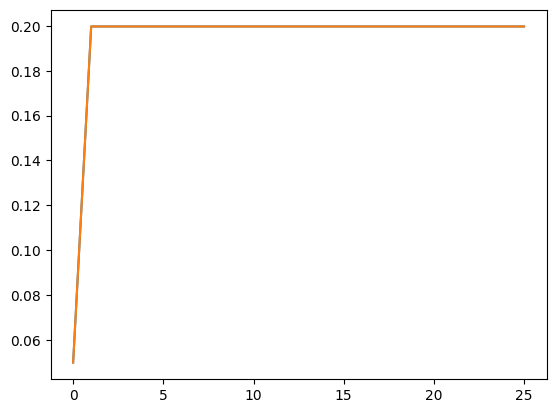

In [83]:
plt.plot(hists0[-1][0])
plt.plot(hists1[-1][0])

In [136]:
print(data1)
data1.validate(raise_on_error=True)

Data(edge_index=[2, 104], pos=[101, 2], vehicle=[101], weight=[104], x=[225, 1])


True

In [137]:
data1.has_self_loops()

False

In [5]:
perm = permutations([1, 2, 3], 2)
print(perm)
 
# Print the obtained permutations 
for i in list(perm): 
    print (list(i))

[1, 2]
[1, 3]
[2, 1]
[2, 3]
[3, 1]
[3, 2]
